In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from libpysal.weights import fuzzy_contiguity
import json
import dask
from dask import delayed, dataframe as dd
from dask.distributed import Client, LocalCluster
from dask.graph_manipulation import bind
import bokeh
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
import glob
import dask.bag as db
from itertools import chain
import json
import warnings
import matplotlib.pyplot as plt
import logging
import dask.config

/tmp/ipykernel_1725/3223235786.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
with open('./out/singapore/clustertess.json', 'r') as f:
    includes_dict = json.load(f)

In [3]:
chunks = gpd.read_parquet('./out/singapore/clusters.pq')

In [4]:
w = fuzzy_contiguity(chunks, buffering=True, buffer=1000)

<Axes: >

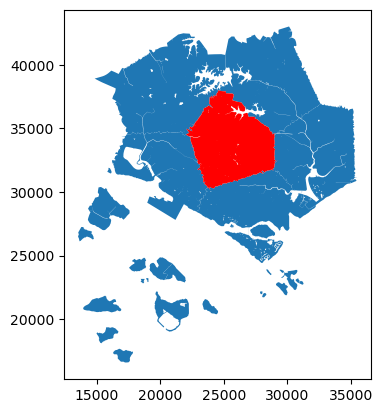

In [5]:
ax = chunks.loc[w.neighbors[2]].plot()
chunks.loc[[2]].plot(ax=ax, color='r')

In [6]:
import dask
dask.config.set({'logging.distributed': 'error'})

In [7]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

2023-04-11 15:42:54,596 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-11 15:42:54,598 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-11 15:42:54,601 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-11 15:42:54,603 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-11 15:42:54,606 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-11 15:42:54,608 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-11 15:42:54,610 - distributed.worker_memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 15.58 GiB
2023-04-11 15

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 124.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46423,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 124.66 GiB
Comm: tcp://127.0.0.1:35415,Total threads: 2
Dashboard: http://127.0.0.1:43585/status,Memory: 15.58 GiB
Nanny: tcp://127.0.0.1:37395,


In [8]:
def duplicates(tessellation):

    # Check for duplicates based on UID
    duplicates = tessellation[tessellation.duplicated(subset='uID', keep=False)]

    # duplicates.to_file( "./out/" + place + 'errors.shp', driver='ESRI Shapefile')

    # Print the duplicate rows
    if len(duplicates) > 0:
        raise Exception("Tesselation: Duplicate UID entries:")
    elif (tessellation["uID"].isnull().values.any()):
        raise Exception("uID column include invalid entries")
    else:
        print("combined_chunk no problems")
        return 0

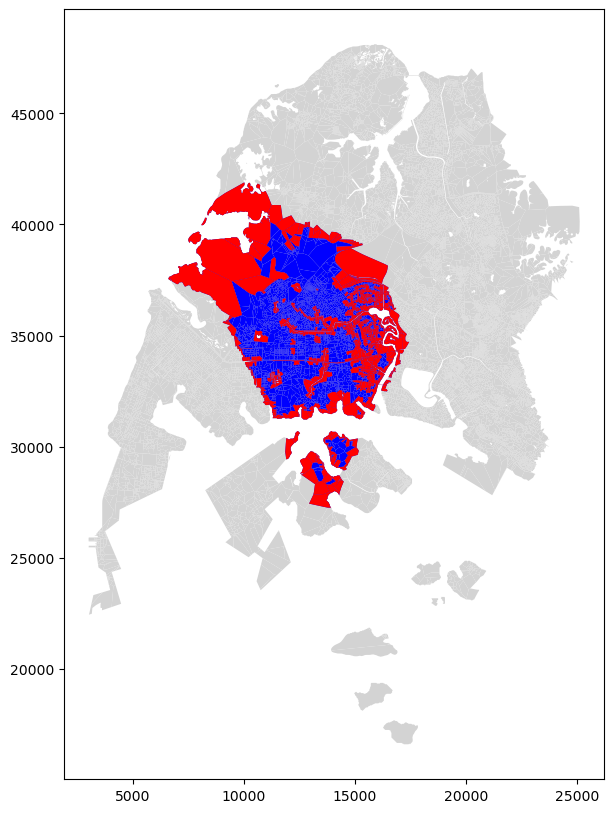

starting expand_one_order, chunk 0 order 3


/home/virgilxw/miniconda3/lib/python3.10/site-packages/cloudpickle/cloudpickle.py:649: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  __import__(name)
/home/virgilxw/miniconda3/lib/python3.10/site-packages/cloudpickle/cloudpickle.py:649: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by 

compute done this wave
chunk 0 , order 3 , sublist 0 of 36
compute done this wave
chunk 0 , order 3 , sublist 1 of 36
compute done this wave
chunk 0 , order 3 , sublist 2 of 36


: 

: 

In [9]:
queen_out = {}

@delayed
def neigh_look(cell, search_chunks): 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore")
        intersects = gpd.sjoin(search_chunks, cell, op='touches', how='inner')

        return intersects.uID_left.tolist()


def expand_one_order(n1, main_chunk_ids, periphery_cells_id, order, combined_chunks):
    
    red_gdf = combined_chunks[combined_chunks['uID'].isin(periphery_cells_id)]
    
    blue_gdf = combined_chunks[combined_chunks['uID'].isin(main_chunk_ids)]
    
    # plot the GeoDataFrames on the same plot
    fig, ax = plt.subplots(figsize=(10, 10))
    combined_chunks.plot(ax=ax, color='lightgray')
    blue_gdf.plot(ax=ax, color='blue')
    red_gdf.plot(ax=ax, color='red')
    plt.show()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore")
    
        print("starting expand_one_order, chunk " + str(n1) + " order " + str(order), flush=True)
                
        if order == 0:
            return main_chunk_ids

        results = set(main_chunk_ids)
        
        search_chunks = combined_chunks[~combined_chunks['uID'].isin(main_chunk_ids + periphery_cells_id)]

        chunk_size = 16
        periphery_cells_id_chunks = [periphery_cells_id[i:i+chunk_size] for i in range(0, len(periphery_cells_id), chunk_size)]
        
        len_sublist = len(periphery_cells_id_chunks)
        for i, sublist in enumerate(periphery_cells_id_chunks):

            delay_objs =[]
            new_results = []
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                delay_objs = [neigh_look(combined_chunks[combined_chunks['uID'] == cell_id], search_chunks) for cell_id in sublist]
                new_results = dask.compute(delay_objs)
                {results.add(new) for new in chain(*new_results[0])}
                
                        
            print("compute done this wave", flush=True)
            print("chunk " + str(n1) + " , order " + str(order) +" , sublist " + str(i) + " of " + str(len_sublist), flush=True)
        
        
        neighbouring_cells = list(results - set(main_chunk_ids))
        
        # find the rows in main_chunk that intersect the buffered polygon
        
        
        print("cells added this wave", flush=True)
    
    return expand_one_order(n1, list(results), neighbouring_cells, order-1, combined_chunks)
    
def process_chunk(n1, order, neighbours, chunk):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore")
            
        main_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n1)}.pq")
        combined_chunks = main_chunk

        main_chunk_ids = list(main_chunk['uID'])
        results = []

        for n2 in neighbours:
            neigh_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n2)}.pq")
            combined_chunks = combined_chunks.append(neigh_chunk)

        combined_chunks = combined_chunks.reindex()

        buffer = gpd.GeoDataFrame(geometry = [chunk.boundary[n1].buffer(5)], crs=main_chunk.crs)
        
        # find the rows in main_chunk that intersect the buffered polygon
        intersecting_rows = gpd.sjoin(main_chunk, buffer, how='inner', op='intersects')
        
        out = expand_one_order(n1, main_chunk_ids, intersecting_rows["uID"].tolist(), order, combined_chunks)
        
        return out

# for n1 in tqdm(range(10), total=10):
#     queen_out[n1] = process_chunk(n1)

file_pattern = "./out/singapore/tess_chunk_*.pq"
file_list = glob.glob(file_pattern)
num_files = len(file_list)

# combined_chunks=[]
# delayed_tasks = []
# for n1 in range(num_files):
#     delayed_task = process_chunk(n1, w, combined_chunks)
#     delayed_tasks.append(delayed_task)

#     results = delayed_tasks

queen_out = [process_chunk(n1, 3, w.neighbors[n1], chunks.loc[[n1]]) for n1 in range(num_files)]


for n1 in tqdm(range(num_files)):
    queen_out[n1].to_parquet(f"./out/singapore/queen_{int(n1)}.pq")

In [ ]:
daskCluster.close()
client.shutdown()


In [ ]:
queen_out.to_parquet("./out/singapore/queen_areas.pq")